In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score, classification_report

In [23]:
# Loading the dataset
transaction_df = pd.read_excel("Transaction.xlsx")
user_df = pd.read_excel("User.xlsx")
city_df = pd.read_excel("City.xlsx")

Transaction DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52930 entries, 0 to 52929
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   TransactionId  52930 non-null  int64
 1   UserId         52930 non-null  int64
 2   VisitYear      52930 non-null  int64
 3   VisitMonth     52930 non-null  int64
 4   VisitMode      52930 non-null  int64
 5   AttractionId   52930 non-null  int64
 6   Rating         52930 non-null  int64
dtypes: int64(7)
memory usage: 2.8 MB
None

Missing Values:
 TransactionId    0
UserId           0
VisitYear        0
VisitMonth       0
VisitMode        0
AttractionId     0
Rating           0
dtype: int64

Basic Statistics:
        TransactionId        UserId     VisitYear    VisitMonth     VisitMode  \
count   52930.000000  52930.000000  52930.000000  52930.000000  52930.000000   
mean    70415.130474  45024.522596   2016.351899      6.633100      2.945759   
std     66299.5

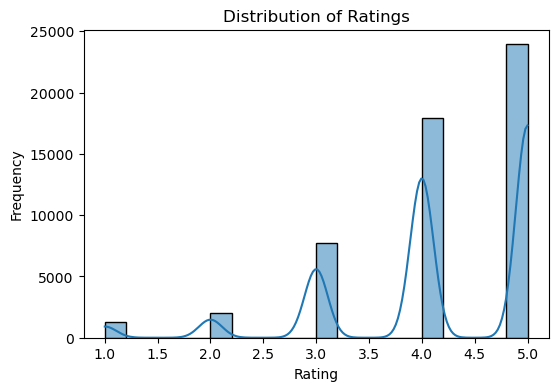

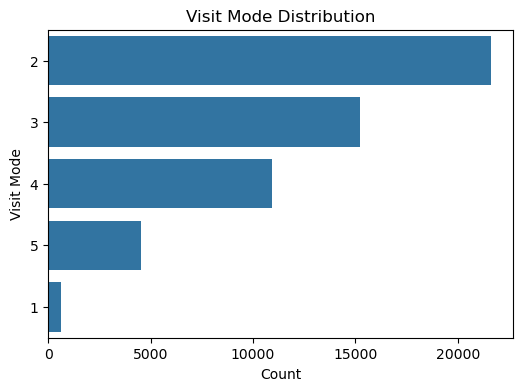

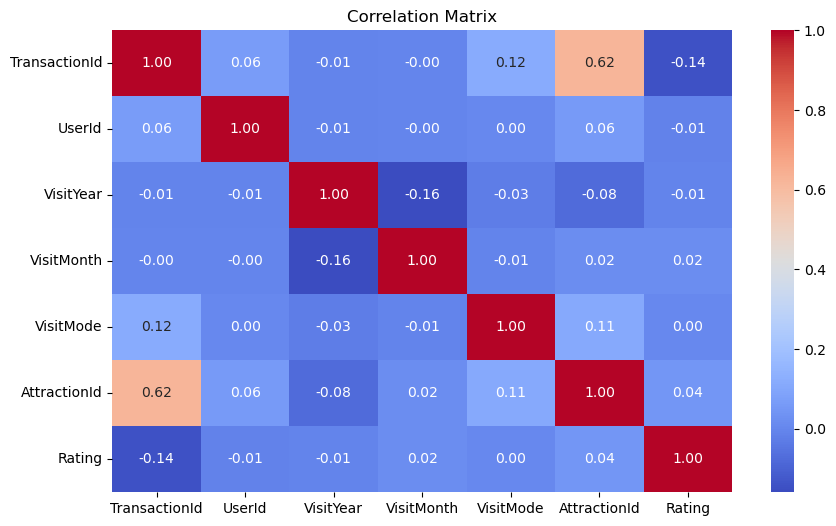

In [24]:
# EDA - Basic Info
print("Transaction DataFrame Overview:")
print(transaction_df.info())
print("\nMissing Values:\n", transaction_df.isnull().sum())
print("\nBasic Statistics:\n", transaction_df.describe())

# Distribution of Ratings
plt.figure(figsize=(6, 4))
sns.histplot(transaction_df["Rating"], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Visit Mode Distribution
plt.figure(figsize=(6, 4))
sns.countplot(y=transaction_df["VisitMode"], order=transaction_df["VisitMode"].value_counts().index)
plt.title("Visit Mode Distribution")
plt.xlabel("Count")
plt.ylabel("Visit Mode")
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(transaction_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [25]:
# Handling Missing data
transaction_df.fillna(method='ffill', inplace=True)
user_df.fillna(method='ffill', inplace=True)
city_df.fillna(method='ffill', inplace=True)

C:\Users\Ragupathy\AppData\Local\Temp\ipykernel_20408\1731639595.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  transaction_df.fillna(method='ffill', inplace=True)
C:\Users\Ragupathy\AppData\Local\Temp\ipykernel_20408\1731639595.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  user_df.fillna(method='ffill', inplace=True)
C:\Users\Ragupathy\AppData\Local\Temp\ipykernel_20408\1731639595.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_df.fillna(method='ffill', inplace=True)


In [26]:
city_df["CityName"] = city_df["CityName"].astype(str).str.title().str.strip()
transaction_df["VisitMode"] = transaction_df["VisitMode"].astype(str).str.title().str.strip()

In [27]:
# Standadization
transaction_df["VisitYear"] = pd.to_numeric(transaction_df["VisitYear"], errors='coerce')
transaction_df["VisitMonth"] = pd.to_numeric(transaction_df["VisitMonth"], errors='coerce')
transaction_df.dropna(subset=["VisitYear", "VisitMonth"], inplace=True)
transaction_df = transaction_df.astype({"VisitYear": "int", "VisitMonth": "int"})

In [28]:
# Handling Outliers
q1 = transaction_df["Rating"].quantile(0.25)
q3 = transaction_df["Rating"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
transaction_df = transaction_df[(transaction_df["Rating"] >= lower_bound) & (transaction_df["Rating"] <= upper_bound)]

In [29]:
# Label Encoder
label_encoders = {}
categorical_columns = ["VisitMode", "Contenent", "Country", "AttractionTypeId"]
for col in categorical_columns:
    if col in transaction_df.columns:
        le = LabelEncoder()
        transaction_df[col] = le.fit_transform(transaction_df[col].astype(str))
        label_encoders[col] = le


In [30]:
user_features = transaction_df.groupby("UserId")["Rating"].mean().reset_index()
user_features.rename(columns={"Rating": "AvgRatingPerUser"}, inplace=True)
consolidated_df = transaction_df.merge(user_features, on="UserId", how="left")
consolidated_df = consolidated_df.merge(user_df, on="UserId", how="left")
consolidated_df = consolidated_df.merge(city_df, on="CityId", how="left")

In [31]:
# Normalization
scaler_rating = MinMaxScaler()
consolidated_df["Rating"] = scaler_rating.fit_transform(consolidated_df[["Rating"]])

scaler_avg = MinMaxScaler()
consolidated_df["AvgRatingPerUser"] = scaler_avg.fit_transform(consolidated_df[["AvgRatingPerUser"]])

In [32]:
features = ["UserId", "CityId", "VisitYear", "VisitMonth", "VisitMode"]
X = consolidated_df[features]
y = consolidated_df["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Results:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    print("-" * 40)
    joblib.dump(model, f"{name.replace(' ', '_')}_Regressor.pkl")

Linear Regression Results:
MAE: 0.32229381793343564
MSE: 0.13091899854516797
RMSE: 0.36182730486403036
----------------------------------------


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest Results:
MAE: 0.30505603020612976
MSE: 0.1361412189748495
RMSE: 0.3689731954693315
----------------------------------------


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Support Vector Regressor Results:
MAE: 0.32150234498087854
MSE: 0.13510307575333078
RMSE: 0.3675637029867486
----------------------------------------


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
consolidated_df.to_excel("preprocessed_data.xlsx", index=False)

In [35]:
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

In [36]:
transaction_df

,TransactionId,UserId,VisitYear,VisitMonth,VisitMode,AttractionId,Rating
0,3,70456,2022,10,1,640,5
1,8,7567,2022,10,3,640,5
2,9,79069,2022,10,2,640,5
3,10,31019,2022,10,2,640,3
4,15,43611,2022,10,1,640,3
...,...,...,...,...,...,...,...
52925,211227,87100,2018,9,1,1297,4
52926,211238,88112,2016,2,1,1297,5
52927,211239,88112,2016,2,1,1297,4
52928,211240,88112,2016,2,1,1297,4


In [37]:



# models = {
#     "Logistic Regression": LogisticRegression(max_iter=500),
#     "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
#     "Support Vector Classifier": SVC()
# }

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
#     print(classification_report(y_test, y_pred))
#     print("-" * 40)
#     joblib.dump(model, f"{name.replace(' ', '_')}_Classifier.pkl")



In [38]:
item_df = pd.read_excel("Item.xlsx")
item_df.rename(columns={"AttractionId": "AttractionId", "AttractionType": "AttractionType"}, inplace=True)

transaction_df = consolidated_df.merge(city_df, on="CityId", how="left")
transaction_df = transaction_df.merge(item_df, on="AttractionId", how="left")
# transaction_df = transaction_df.merge(user_df, on="UserId", how="left", suffixes=("_trans", "_user"))

print(transaction_df.columns)




Index(['TransactionId', 'UserId', 'VisitYear', 'VisitMonth', 'VisitMode',
       'AttractionId', 'Rating', 'AvgRatingPerUser', 'ContenentId', 'RegionId',
       'CountryId_x', 'CityId', 'CityName_x', 'CountryId_y', 'CityName_y',
       'CountryId', 'AttractionCityId', 'AttractionTypeId', 'Attraction',
       'AttractionAddress'],
      dtype='object')


In [39]:
label_encoders = {}
categorical_columns = ["Contenent", "Region", "Country", "City", "AttractionType", "VisitMode"]
transaction_df

for col in categorical_columns:
    if col in transaction_df.columns:
        le = LabelEncoder()
        transaction_df[col] = le.fit_transform(transaction_df[col].astype(str))
        label_encoders[col] = le
        joblib.dump(le, f"{col}_encoder.pkl")


In [40]:
features = ["UserId", "CityId", "VisitYear", "VisitMonth", "AttractionTypeId"]
X = transaction_df[features]
y = transaction_df["VisitMode"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Classifier": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 40)
    joblib.dump(model, f"{name.replace(' ', '_')}_Classifier.pkl")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

Logistic Regression Accuracy: 0.4058
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.40      0.99      0.57      4007
           2       0.50      0.02      0.04      2912
           3       0.00      0.00      0.00      2004
           4       0.00      0.00      0.00       866

    accuracy                           0.41      9927
   macro avg       0.18      0.20      0.12      9927
weighted avg       0.31      0.41      0.24      9927

----------------------------------------
Random Forest Accuracy: 0.5454
              precision    recall  f1-score   support

           0       0.51      0.20      0.28       138
           1       0.56      0.71      0.63      4007
           2       0.57      0.55      0.56      2912
           3       0.46      0.35      0.40      2004
           4       0.53      0.26      0.35       866

    accuracy                           0.55      9927
   macro avg       0.5

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
